In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import xml.etree.ElementTree as ET
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

In [2]:
images_dir = "C:/Users/Lenovo/Desktop/coviddataset/images"
annotations_dir = "C:/Users/Lenovo/Desktop/coviddataset/annotations"

#initializing hyperparameters
num_epochs = 20
batch_size = 32
image_size = (256, 256) 
num_classes = 3 

In [3]:
# class to prepare dataset from images and annotations
class MaskDetectionDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None, file_list=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        if file_list is None:
            self.image_files = os.listdir(images_dir)
        else:
            self.image_files = file_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        annotation_path = os.path.join(self.annotations_dir, image_file.replace(".png", ".xml"))

        img = Image.open(image_path).convert("RGB").resize(image_size)
        img_tensor = self.transform(img)

        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall("object")

        if len(objects) > 0:
            xmin = float(objects[0].find("bndbox").find("xmin").text)
            ymin = float(objects[0].find("bndbox").find("ymin").text)
            xmax = float(objects[0].find("bndbox").find("xmax").text)
            ymax = float(objects[0].find("bndbox").find("ymax").text)

        class_label = objects[0].find("name").text if len(objects) > 0 else "without_mask"
        class_label = class_label.lower()

        class_dict = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
        class_id = class_dict[class_label]
        class_tensor = torch.tensor(class_id, dtype=torch.long).unsqueeze(0)

        return img_tensor, class_tensor

In [4]:
class EfficientNetCNN(nn.Module):
    def __init__(self, num_classes=3, model_name='efficientnet-b0', pretrained=True):
        super(EfficientNetCNN, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained(model_name) if pretrained else EfficientNet.from_name(model_name)
        num_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [5]:
# Splitting data into training, validation, and test
all_image_files = os.listdir(images_dir)
train_files, temp_files = train_test_split(all_image_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_dataset = MaskDetectionDataset(images_dir, annotations_dir, transform=transform, file_list=train_files)
val_dataset = MaskDetectionDataset(images_dir, annotations_dir, transform=transform, file_list=val_files)
test_dataset = MaskDetectionDataset(images_dir, annotations_dir, transform=transform, file_list=test_files)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#initialing the model
model = EfficientNetCNN(num_classes=3, model_name='efficientnet-b0', pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 24.5MB/s]


Loaded pretrained weights for efficientnet-b0


In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted_train == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy_train = correct_predictions_train / total_samples_train
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy_train)

    model.eval()
    correct_predictions_val = 0
    total_samples_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images_val, labels_val in val_loader:
            images_val, labels_val = images_val.to(device), labels_val.to(device).squeeze(1)

            outputs_val = model(images_val)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_samples_val += labels_val.size(0)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            val_loss += criterion(outputs_val, labels_val).item()

    epoch_accuracy_val = correct_predictions_val / total_samples_val
    epoch_val_loss = val_loss / len(val_loader)
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_accuracy_val)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Train Accuracy: {epoch_accuracy_train:.4f}, Validation Accuracy: {epoch_accuracy_val:.4f}")


Epoch [1/20], Loss: 0.8501, Train Accuracy: 0.7082, Validation Accuracy: 0.8235
Epoch [2/20], Loss: 0.5864, Train Accuracy: 0.8094, Validation Accuracy: 0.8235
Epoch [3/20], Loss: 0.5681, Train Accuracy: 0.8094, Validation Accuracy: 0.8235
Epoch [4/20], Loss: 0.5058, Train Accuracy: 0.8182, Validation Accuracy: 0.8235
Epoch [5/20], Loss: 0.4636, Train Accuracy: 0.8387, Validation Accuracy: 0.8471
Epoch [6/20], Loss: 0.4566, Train Accuracy: 0.8387, Validation Accuracy: 0.8471
Epoch [7/20], Loss: 0.4203, Train Accuracy: 0.8460, Validation Accuracy: 0.8706
Epoch [8/20], Loss: 0.4046, Train Accuracy: 0.8680, Validation Accuracy: 0.8824
Epoch [9/20], Loss: 0.3884, Train Accuracy: 0.8651, Validation Accuracy: 0.8824
Epoch [10/20], Loss: 0.3788, Train Accuracy: 0.8695, Validation Accuracy: 0.8941
Epoch [11/20], Loss: 0.3457, Train Accuracy: 0.8798, Validation Accuracy: 0.9059
Epoch [12/20], Loss: 0.3346, Train Accuracy: 0.8856, Validation Accuracy: 0.9059
Epoch [13/20], Loss: 0.3441, Train Ac

In [10]:
model.eval()
correct_predictions_test = 0
total_samples_test = 0

with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device).squeeze(1)

        outputs_test = model(images_test)
        _, predicted_test = torch.max(outputs_test.data, 1)
        total_samples_test += labels_test.size(0)
        correct_predictions_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_predictions_test / total_samples_test
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9070


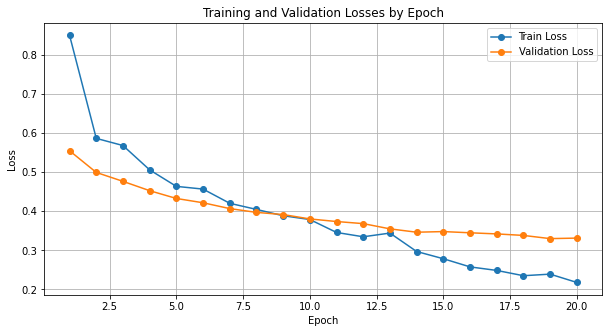

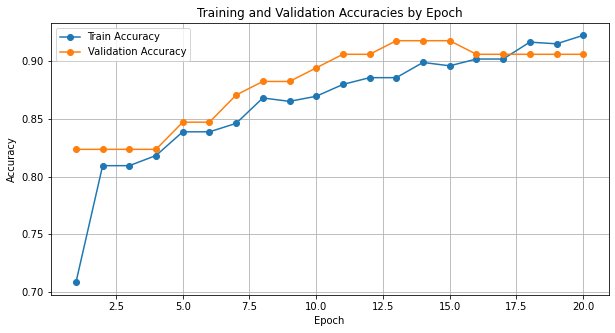

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses by Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies by Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def predict_image_class(model, image_path):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
        class_id = predicted.item()

    class_dict_reverse = {0: "with_mask", 1: "without_mask", 2: "mask_weared_incorrect"}
    predicted_class = class_dict_reverse[class_id]

    return predicted_class

In [13]:
def display_and_predict(image_path, predicted_class):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

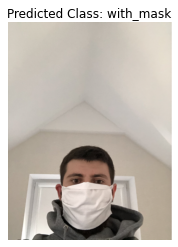

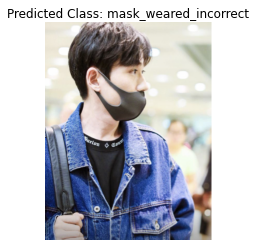

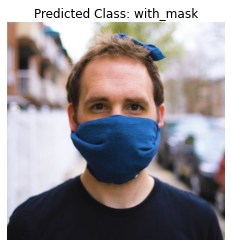

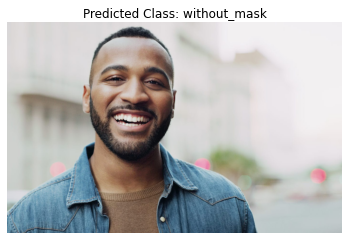

In [14]:
import matplotlib.image as mpimg

image_path = "C:/Users/Lenovo/Desktop/coviddataset/images/maksssksksss10.png"
image_path_2 = "C:/Users/Lenovo/Desktop/coviddataset/images/maksssksksss132.png"
image_path_3 = "C:/Users/Lenovo/Pictures/propermask.jpg"
image_path_4 = "C:/Users/Lenovo/Pictures/withoutmask.jpg"

predicted_class = predict_image_class(model, image_path)
predicted_class_2 = predict_image_class(model, image_path_2)
predicted_class_3 = predict_image_class(model, image_path_3)
predicted_class_4 = predict_image_class(model, image_path_4)

display_and_predict(image_path, predicted_class)
display_and_predict(image_path_2, predicted_class_2)
display_and_predict(image_path_3, predicted_class_3)
display_and_predict(image_path_4, predicted_class_4)